In [7]:
import pandas as pd
import math
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline  
import statsmodels as st
import statsmodels.api as sm
from scipy import stats
from pandas import DataFrame
from datetime import datetime
from sklearn.model_selection import train_test_split
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error, r2_score
from dateutil.parser import parse
import scipy.stats as scs
from pylab import rcParams
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from matplotlib.pylab import rcParams

#Stop warnings
import warnings
warnings.filterwarnings("ignore")

#### Read Data

In [8]:
def read_CLEAN_data(filename):
    #Read in CSV file
    dat = pd.read_csv(filename)
    #Convert datetimes
    dat["Date"] = pd.to_datetime(dat["Date"], format = '%Y-%m-%d').dt.date
    
    return dat
# 10 hours of non zeroes 
def adherence_check1(df):
  df1 = df.copy()
  df1['Not Zero'] = df1['Steps'] > 0
  df1 = df1.groupby('Date').sum()
  df1 = df1['Not Zero'] > 10 
  return df1

#Greater than 500 steps
def adherence_check2(df,min):
  df1 = df.copy()
  df1 = df1.groupby('Date').sum()
  df1 = df1['Steps']> min
  return df1 

#Active in 3 time blocks 
def adherence_check3(df):
  df1 = df.copy()
  bins = [-1,2,10,14,25,np.inf]
  names = ['3','1','2', '3', '3']
  df1['3timeblock'] = pd.cut(df1['Hour'],bins, labels = names, ordered=False)
  df1 = df1.groupby(['Date','3timeblock'], as_index=False)['Steps'].sum()
  df1['Steps within timeblock'] = df1['Steps']> 0 
  df1 = df1.groupby('Date').sum()
  df1 = df1['Steps within timeblock'] ==3 
  return df1

#Combining it all into 1 dataframe
def three_method_table(x):
  valid_1= adherence_check1(x)
  valid_2= adherence_check2(x,500)
  #valid_3= adherence_check3(x)
  #result = pd.concat([valid_1,valid_2,valid_3], axis=1, join='inner')
  result = pd.concat([valid_1,valid_2], axis=1, join='inner')
  result.reset_index(level=0, inplace=True)
  #result.columns = ["Date", "10 Hours Non Zero","Steps > 500","3 Timeblock"]
  result.columns = ["Date", "10 Hours Non Zero","Steps > 500"]
  #result['All 3 True'] = result["3 Timeblock"]*result["10 Hours Non Zero"]*result["Steps > 500"]
  result['All 3 True'] = result["10 Hours Non Zero"]*result["Steps > 500"]
  result_sum = result.sum()
  return result , result_sum

def filter_by_adherence(df, measure):
    df2 = three_method_table(df)[0]
    df3 = df.merge(df2,on ='Date')
    if(measure == 1):
        mask = (df3['10 Hours Non Zero'] == True)
    elif(measure == 2):
        mask = (df3['Steps > 500'] == True)
    elif(measure == 3):
        mask = (df3['All 3 True'] == True)
    filtered_df = df3.loc[mask].drop(['10 Hours Non Zero', 'Steps > 500', 'All 3 True'], axis=1)
    #filtered_df = filtered_df.drop('index', axis=1)
    return filtered_df

# Method 1 calculates daily steps based on all the step acitivity that is available during the day
def run_method_1(df):
    
    df["Date"] = pd.to_datetime(df["Date"],format='%Y-%m-%d')
    df.index = df["Date"]
    daily_step_count = df.drop(['Hour'], axis=1).resample('D').sum(min_count=1).dropna().reset_index()
    
    return(daily_step_count)

# Method 2 calculates daily steps based on the 10 most active hours of the day
def run_method_2(df):
    
    df = df.sort_values(by=["Date", "Steps"], ascending=False).groupby('Date').head(10)
    df["Date"] = pd.to_datetime(df["Date"],format='%Y-%m-%d')
    df.index = df["Date"]
    daily_step_count = df.drop(['Hour'], axis=1).resample('D').sum(min_count=1).dropna().reset_index()
    
    return(daily_step_count)

# Method 3 calculates daily steps based on a 10 hour time block during the day
def run_method_3(df, start_hour, end_hour):
    
    df["Date"] = pd.to_datetime(df["Date"],format='%Y-%m-%d')
    mask = (df['Hour'] >= start_hour) & (df['Hour'] <= end_hour)
    df = df.loc[mask]
    df.index = df["Date"]
    daily_step_count = df.drop(['Hour'], axis=1).resample('D').sum(min_count=1).dropna().reset_index()
    
    return(daily_step_count)

def calculate_daily_steps(file_name, filter_measure, start_time, end_time):
    
    df = read_CLEAN_data(filename)
    filtered_df = filter_by_adherence(df, filter_measure)
    
    dailysteps_method2 = run_method_2(filtered_df)
    dailysteps_method1 = run_method_1(filtered_df)
    dailysteps_method3 = run_method_3(filtered_df, start_time, end_time)
    
   
    return dailysteps_method1,dailysteps_method2,dailysteps_method3

In [9]:
filename = "user2.csv"

filter_measure = 3
start_time = 8
end_time = 18

ds_method1, ds_method2, ds_method3 = calculate_daily_steps(filename, filter_measure, start_time, end_time)

#### Method 1

In [10]:
ds_method1.set_index('Date',inplace=True)
ds_method1.shape

(1720, 1)

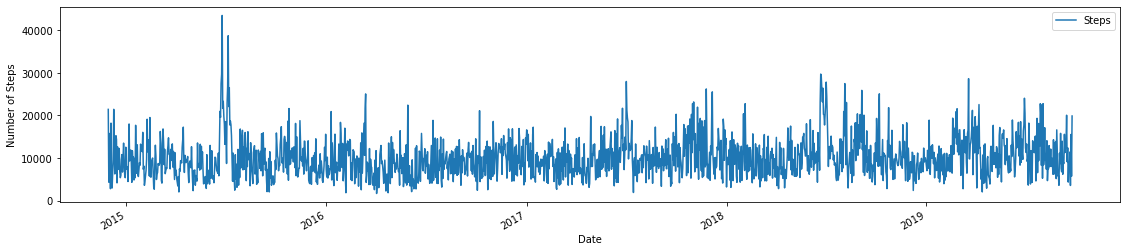

In [11]:
ds_method1.plot(figsize=(19, 4))
plt.ylabel("Number of Steps")
plt.show()

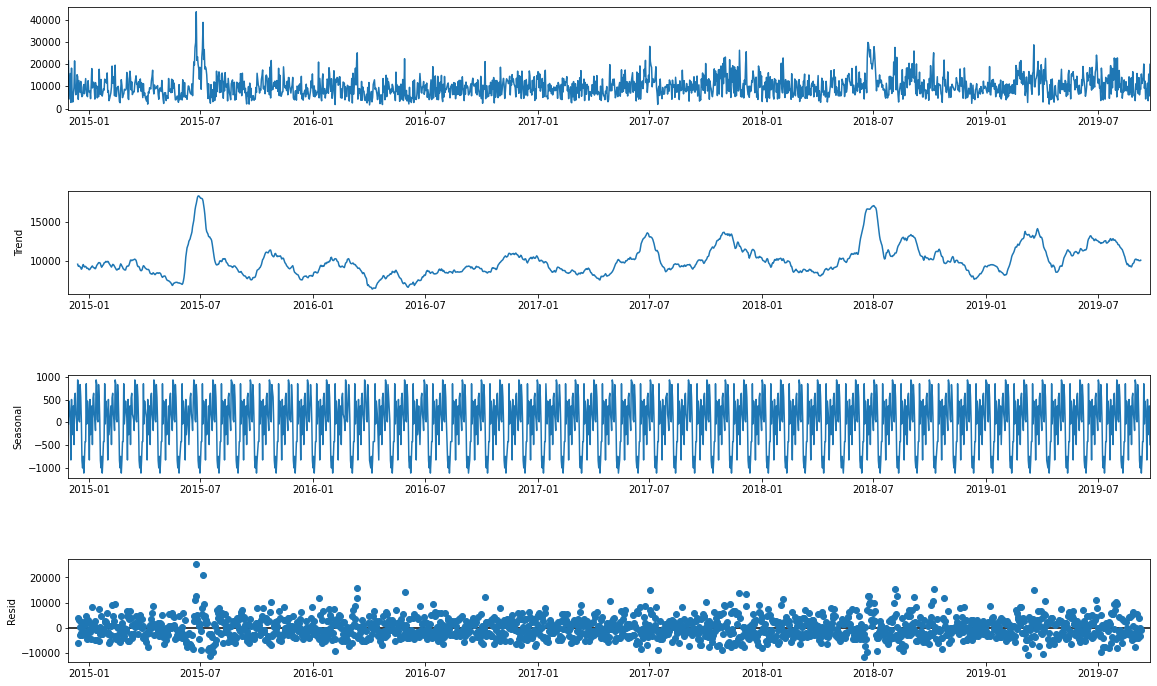

In [12]:
decomposition = sm.tsa.seasonal_decompose(ds_method1, model='additive', freq = 30)
fig = decomposition.plot()
fig.set_size_inches(18.5, 10.5)
plt.show()

The data still has seasonality 

#### Check for data stationary

In [13]:
def test_stationarity(timeseries):
    
    #Determine rolling statistics
    movingAverage = timeseries.rolling(window=12).mean()
    movingSTD = timeseries.rolling(window=12).std()
    
    #Plot rolling statistics
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(movingAverage, color='red', label='Rolling Mean')
    std = plt.plot(movingSTD, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.xlabel("Date")
    plt.ylabel("Number of Steps")
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    
    #Perform Dickey–Fuller test:
    print('Results of Dickey Fuller Test:')
    dftest = adfuller(timeseries['Steps'], autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

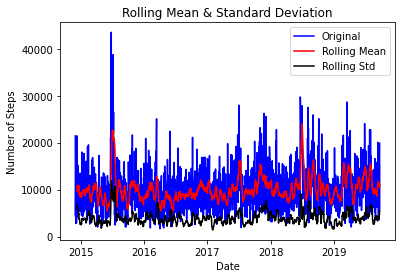

Results of Dickey Fuller Test:
ADF Test Statistic            -8.143732e+00
p-value                        1.011913e-12
#Lags Used                     1.400000e+01
Number of Observations Used    1.705000e+03
Critical Value (1%)           -3.434191e+00
Critical Value (5%)           -2.863237e+00
Critical Value (10%)          -2.567673e+00
dtype: float64


In [14]:
test_stationarity(ds_method1)

For this, we will use the $\alpha$ value of 0.05 to check against the p-value of 1.011913e-12 to decide if we will accept or reject the $H_0$. As $\alpha$ > p-value, we can conclude that the data is stationary.

#### (S)ARIMA Parameters

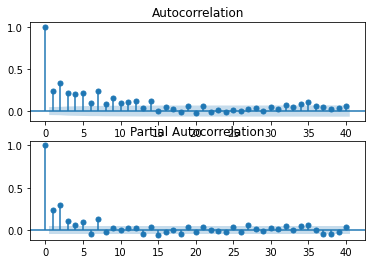

In [15]:
import matplotlib.pyplot as plt
import statsmodels.api as sm
fig, ax = plt.subplots(2,1)
fig = sm.graphics.tsa.plot_acf(ds_method1, ax=ax[0], lags = 40)
fig = sm.graphics.tsa.plot_pacf(ds_method1, ax=ax[1], lags = 40)
plt.show()

In [16]:
from pmdarima.arima import auto_arima
stepwise_model = auto_arima(ds_method1, start_p=0, start_q=0,
                           max_p=4, max_q=4, m=12,
                            seasonal=True,
                           d=0 , trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(stepwise_model.aic())

Fit ARIMA: order=(0, 0, 0) seasonal_order=(1, 0, 1, 12); AIC=33984.435, BIC=34006.236, Fit time=1.075 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 0, 12); AIC=34008.470, BIC=34019.370, Fit time=0.048 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 0, 0, 12); AIC=33898.980, BIC=33920.780, Fit time=0.795 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 0, 1, 12); AIC=33927.862, BIC=33949.662, Fit time=0.413 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(0, 0, 0, 12); AIC=33909.258, BIC=33925.609, Fit time=0.127 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(2, 0, 0, 12); AIC=33895.920, BIC=33923.170, Fit time=2.367 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(2, 0, 1, 12); AIC=33895.548, BIC=33928.248, Fit time=5.983 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(2, 0, 1, 12); AIC=33985.971, BIC=34013.222, Fit time=4.650 seconds
Fit ARIMA: order=(2, 0, 0) seasonal_order=(2, 0, 1, 12); AIC=33748.839, BIC=33786.989, Fit time=5.601 seconds
Fit ARIMA:

So, the best set of parameters to select is ARIMA(4,0,2)(1,0,0,12). I selected m = 12 to represent the yearly number of months each 'season' runs for.

Optimization terminated successfully.
         Current function value: 9.803078
         Iterations: 8
         Function evaluations: 744


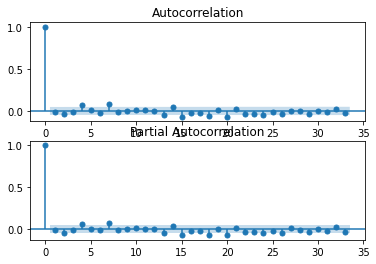

In [17]:
model = sm.tsa.statespace.SARIMAX(ds_method1, order=(4,0,2), seasonal_order = (1,0,0,12)).fit(max_iter=50, method='powell')
res = model.resid
fig, ax = plt.subplots(2,1)
fig = sm.graphics.tsa.plot_acf(res, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(res, ax=ax[1])
plt.show()

In [22]:
train = ds_method1.loc['2014-11-29':'2018-10-10']
test = ds_method1.loc['2019-09-24':]
stepwise_model.fit(train)

ARIMA(callback=None, disp=0, maxiter=None, method=None, order=(4, 0, 2),
   out_of_sample_size=0, scoring='mse', scoring_args={},
   seasonal_order=(1, 0, 0, 12), solver='lbfgs', start_params=None,
   suppress_warnings=True, transparams=True, trend=None,
   with_intercept=True)

In [23]:
mod = sm.tsa.statespace.SARIMAX(ds_method1,
                                order=(4, 0, 2),
                                seasonal_order=(1, 0, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary())

                                      SARIMAX Results                                      
Dep. Variable:                               Steps   No. Observations:                 1720
Model:             SARIMAX(4, 0, 2)x(1, 0, [], 12)   Log Likelihood              -16698.029
Date:                             Wed, 18 Nov 2020   AIC                          33412.059
Time:                                     04:46:46   BIC                          33455.585
Sample:                                          0   HQIC                         33428.170
                                            - 1720                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8431      0.166      5.076      0.000       0.518       1.169
ar.L2          0.4436      

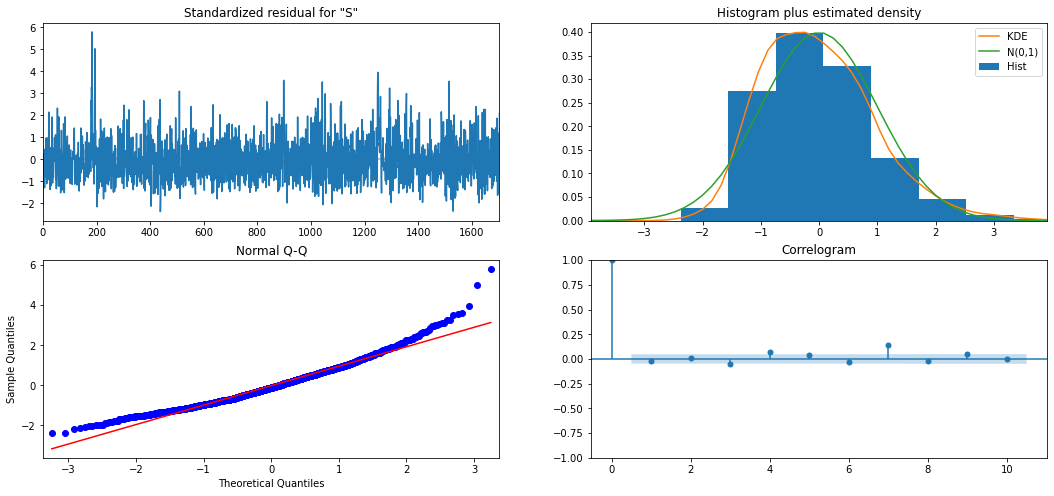

In [24]:
results.plot_diagnostics(figsize=(18, 8))
plt.show()

#### (S)ARIMA Model Validation

In [25]:
from sklearn.metrics import mean_squared_error, mean_absolute_error 

In [26]:
# the 20% point test data is on the specified date below
split_date = '2018-10-10'
data = ds_method1['Steps']
train, test = data[:split_date], data[split_date:]
test_len = len(test)
model = sm.tsa.statespace.SARIMAX(train,
                                order=(4, 0, 2),
                                seasonal_order=(1, 0, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
model_fit = model.fit(disp=-1)
prediction = model_fit.forecast(test_len)

In [27]:
pred_df = pd.DataFrame(np.array(prediction), index= test.index)
mae1 = mean_absolute_error(test.dropna(), pred_df.dropna())
mse1 = mean_squared_error(test.dropna(), pred_df.dropna())
rmse1 = math.sqrt(mse1)
print(f'Mean Squared Error: {mse1.round(4)}')
print(f'Root Mean Squared Error: {round(rmse1,4)}')
print(f'Mean Absolute Error: {mae1.round(4)}')

Mean Squared Error: 20523408.5787
Root Mean Squared Error: 4530.2769
Mean Absolute Error: 3625.2001


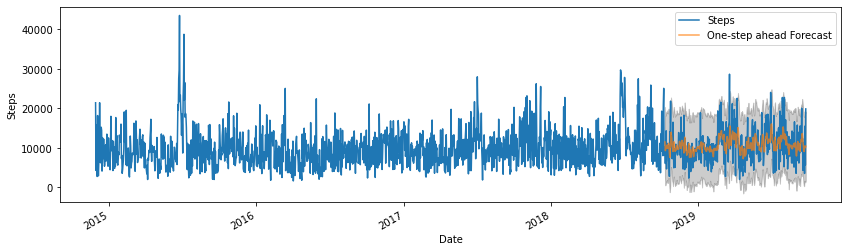

In [28]:
pred = results.get_prediction(start=pd.to_datetime('2018-10-10'), dynamic=False)
pred_ci = pred.conf_int()
#Potentially change the start date so its more zoomed in? 
ax = ds_method1['2014':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 4))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Steps')
plt.legend()
plt.show()

#### Method 2

In [29]:
ds_method2.set_index('Date',inplace=True)
ds_method2.shape

(1720, 1)

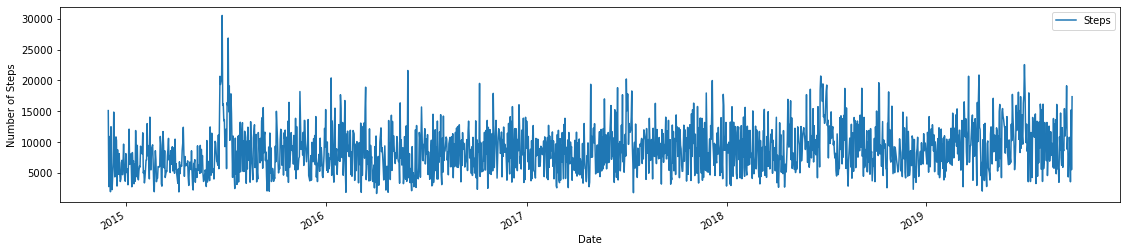

In [30]:
ds_method2.plot(figsize=(19, 4))
plt.ylabel("Number of Steps")
plt.show()

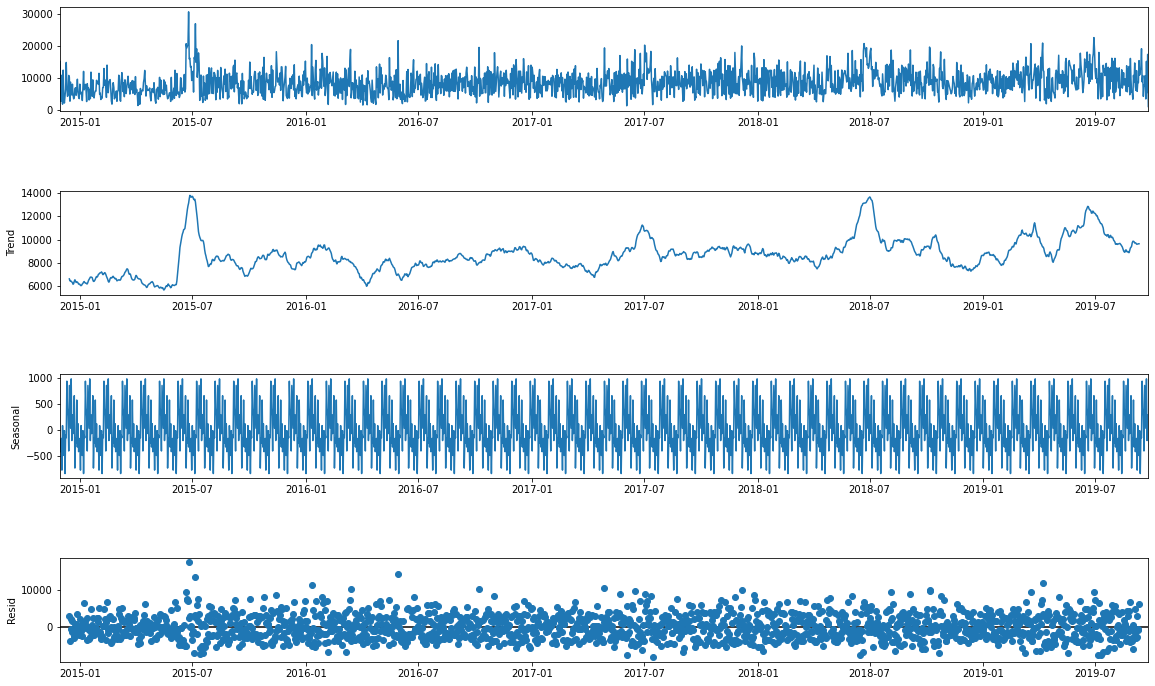

In [28]:
decomposition = sm.tsa.seasonal_decompose(ds_method2, model='additive', period = 30)
fig = decomposition.plot()
fig.set_size_inches(18.5, 10.5)
plt.show()

Again, data is seasonable

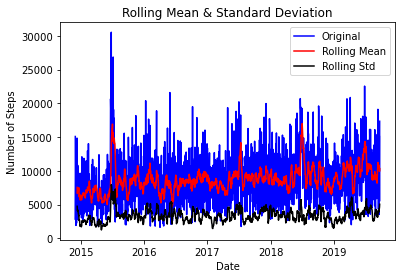

Results of Dickey Fuller Test:
ADF Test Statistic            -7.151627e+00
p-value                        3.130272e-10
#Lags Used                     1.300000e+01
Number of Observations Used    1.706000e+03
Critical Value (1%)           -3.434189e+00
Critical Value (5%)           -2.863236e+00
Critical Value (10%)          -2.567673e+00
dtype: float64


In [31]:
test_stationarity(ds_method2)

Data appears to be stationary

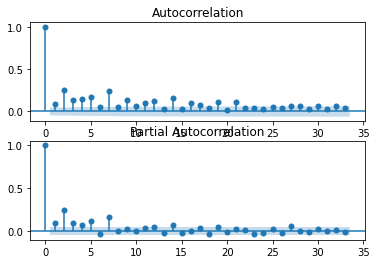

In [32]:
fig, ax = plt.subplots(2,1)
fig = sm.graphics.tsa.plot_acf(ds_method2, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(ds_method2,ax=ax[1])
plt.show()

In [33]:
stepwise_model = auto_arima(ds_method2, start_p=0, start_q=0,
                           max_p=4, max_q=5, m=12,
                            seasonal=True,
                           d=0,  trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(stepwise_model.aic())

Fit ARIMA: order=(0, 0, 0) seasonal_order=(1, 0, 1, 12); AIC=34482.225, BIC=34504.025, Fit time=1.559 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 0, 12); AIC=33244.489, BIC=33255.389, Fit time=0.042 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 0, 0, 12); AIC=33219.598, BIC=33241.399, Fit time=0.907 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 0, 1, 12); AIC=33215.159, BIC=33236.959, Fit time=0.358 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(1, 0, 1, 12); AIC=33217.060, BIC=33244.310, Fit time=1.415 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 0, 0, 12); AIC=33236.670, BIC=33253.020, Fit time=0.141 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 0, 2, 12); AIC=33216.858, BIC=33244.109, Fit time=0.789 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(1, 0, 2, 12); AIC=33218.752, BIC=33251.453, Fit time=4.125 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(0, 0, 1, 12); AIC=33192.982, BIC=33220.232, Fit time=0.492 seconds
Fit ARIMA:

Best SARIMA is order=(4, 0, 4) seasonal_order=(0, 0, 0, 12)

Optimization terminated successfully.
         Current function value: 9.604814
         Iterations: 7
         Function evaluations: 737


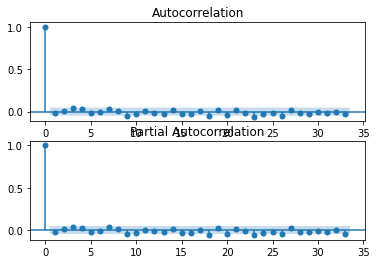

In [34]:
model = sm.tsa.statespace.SARIMAX(ds_method2, order=(4,0,4), seasonal_order = (0,0,0,12)).fit(max_iter=50, method='powell')
res = model.resid
fig, ax = plt.subplots(2,1)
fig = sm.graphics.tsa.plot_acf(res,  ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(res,  ax=ax[1])
plt.show()

In [36]:
train = ds_method2.loc['2014-11-29':'2018-10-10']
test = ds_method2.loc['2019-09-24':]
stepwise_model.fit(train)

ARIMA(callback=None, disp=0, maxiter=None, method=None, order=(4, 0, 4),
   out_of_sample_size=0, scoring='mse', scoring_args={},
   seasonal_order=(0, 0, 0, 12), solver='lbfgs', start_params=None,
   suppress_warnings=True, transparams=True, trend=None,
   with_intercept=True)

In [37]:
mod = sm.tsa.statespace.SARIMAX(ds_method2,
                                order=(4,0,4),
                                seasonal_order=(0, 0, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:                  Steps   No. Observations:                 1720
Model:               SARIMAX(4, 0, 4)   Log Likelihood              -16469.062
Date:                Wed, 18 Nov 2020   AIC                          32956.124
Time:                        04:52:29   BIC                          33005.148
Sample:                             0   HQIC                         32974.265
                               - 1720                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4662      0.191     -2.439      0.015      -0.841      -0.092
ar.L2          0.8990      0.136      6.619      0.000       0.633       1.165
ar.L3          0.6906      0.156      4.434      0.0

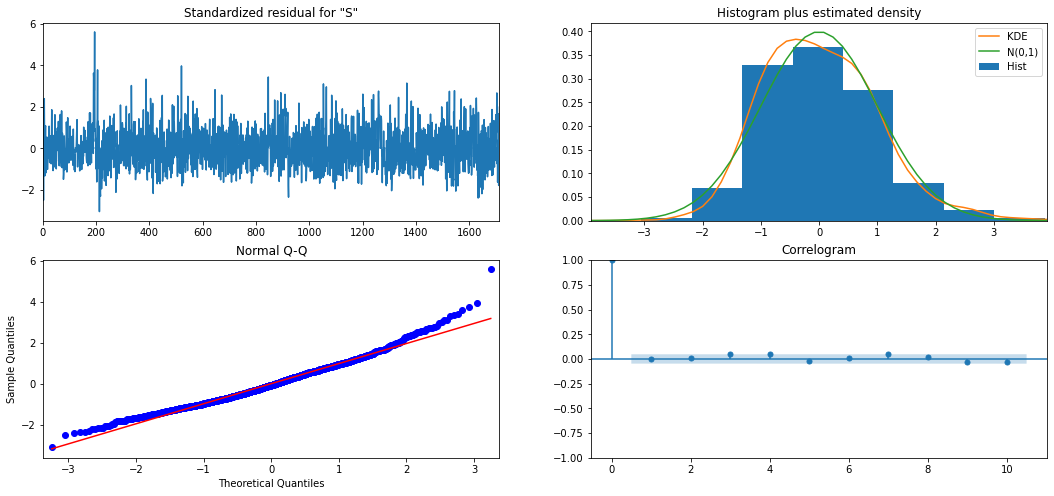

In [38]:
results.plot_diagnostics(figsize=(18, 8))
plt.show()

In [39]:
# the 20% point test data is on the specified date below
split_date = '2018-10-10'
data = ds_method2['Steps']
train, test = data[:split_date], data[split_date:]
test_len = len(test)
model = sm.tsa.statespace.SARIMAX(train,
                                order=(4,0,4),
                                seasonal_order=(0, 0, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
model_fit = model.fit(disp=-1)
prediction = model_fit.forecast(test_len)

In [40]:
pred_df = pd.DataFrame(np.array(prediction), index= test.index)
mae2 = mean_absolute_error(test.dropna(), pred_df.dropna())
mse2 = mean_squared_error(test.dropna(), pred_df.dropna())
rmse2 = math.sqrt(mse2)
print(f'Mean Squared Error: {mse2.round(4)}')
print(f'Root Mean Squared Error: {round(rmse2,4)}')
print(f'Mean Absolute Error: {mae2.round(4)}')

Mean Squared Error: 15350834.1856
Root Mean Squared Error: 3918.0141
Mean Absolute Error: 3220.2339


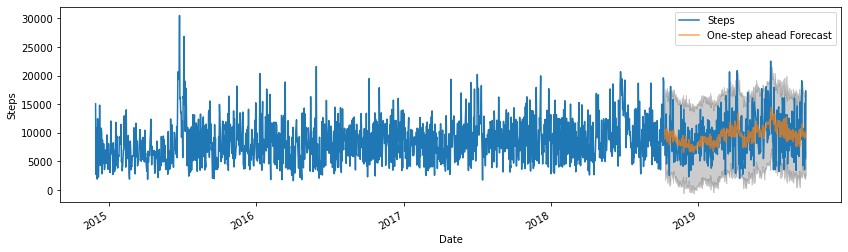

In [41]:
pred = results.get_prediction(start=pd.to_datetime('2018-10-10'), dynamic=False)
pred_ci = pred.conf_int()
#Potentially change the start date so its more zoomed in? 
ax = ds_method2['2014':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 4))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Steps')
plt.legend()
plt.show()

#### Method 3

In [42]:
ds_method3.set_index('Date',inplace=True)
ds_method3.shape

(1720, 1)

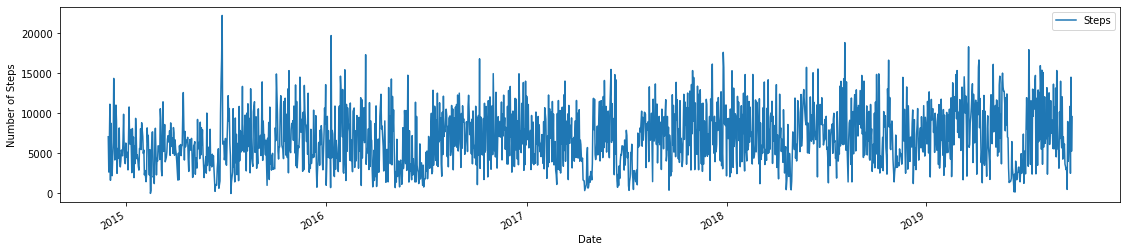

In [43]:
ds_method3.plot(figsize=(19, 4))
plt.ylabel("Number of Steps")
plt.show()

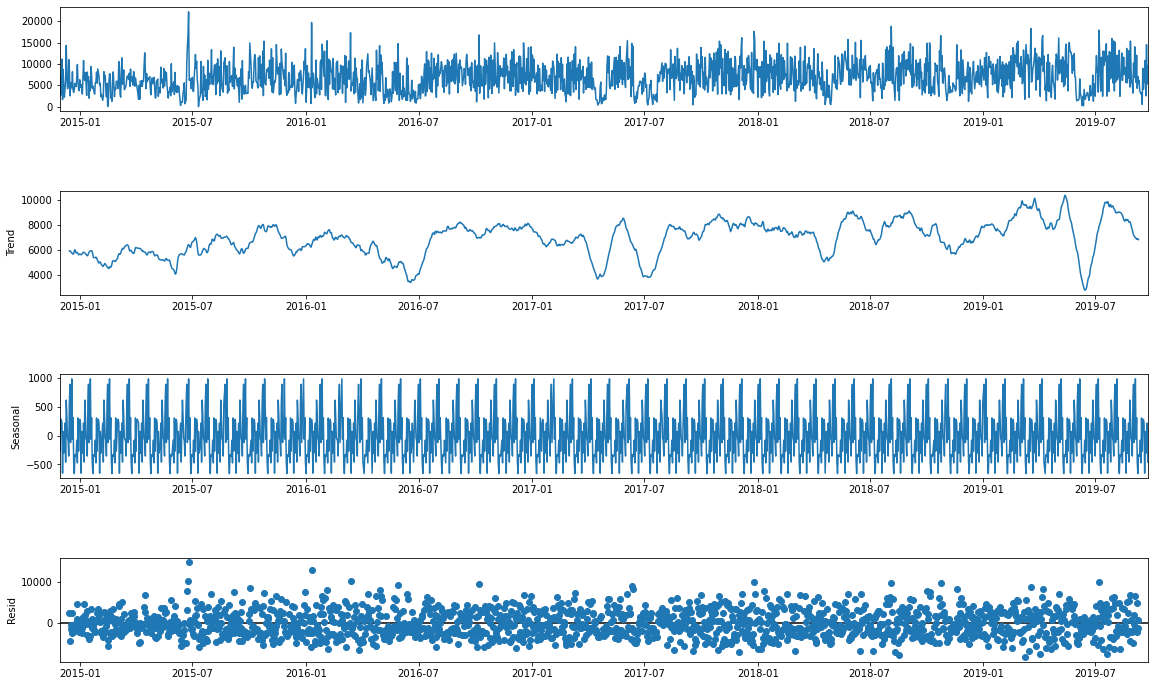

In [44]:
decomposition = sm.tsa.seasonal_decompose(ds_method3, model='additive', period = 30)
fig = decomposition.plot()
fig.set_size_inches(18.5, 10.5)
plt.show()

Again, our data is seasonal

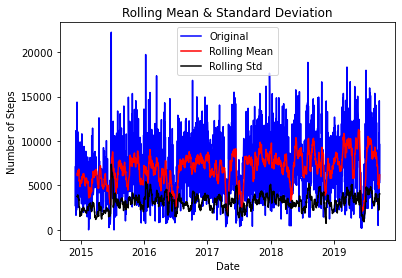

Results of Dickey Fuller Test:
ADF Test Statistic            -6.247935e+00
p-value                        4.527629e-08
#Lags Used                     2.000000e+01
Number of Observations Used    1.699000e+03
Critical Value (1%)           -3.434205e+00
Critical Value (5%)           -2.863243e+00
Critical Value (10%)          -2.567676e+00
dtype: float64


In [45]:
test_stationarity(ds_method3)

P-value is significant, our data is stationary

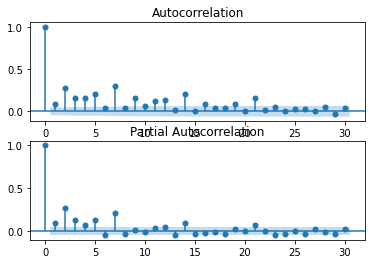

In [46]:
fig, ax = plt.subplots(2,1)
fig = sm.graphics.tsa.plot_acf(ds_method3, lags=30, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(ds_method3, lags=30, ax=ax[1])
plt.show()

In [47]:
stepwise_model = auto_arima(ds_method3, start_p=0, start_q=0,
                           max_p=4, max_q=4, m=12,
                            seasonal=True,
                           d=0,  trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(stepwise_model.aic())

Fit ARIMA: order=(0, 0, 0) seasonal_order=(1, 0, 1, 12); AIC=33701.624, BIC=33723.424, Fit time=1.754 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 0, 12); AIC=33030.540, BIC=33041.441, Fit time=0.025 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 0, 0, 12); AIC=33003.287, BIC=33025.087, Fit time=0.539 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 0, 1, 12); AIC=32996.062, BIC=33017.863, Fit time=0.286 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(1, 0, 1, 12); AIC=32997.766, BIC=33025.017, Fit time=1.203 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 0, 0, 12); AIC=33023.760, BIC=33040.110, Fit time=0.136 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 0, 2, 12); AIC=32998.061, BIC=33025.312, Fit time=0.724 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(1, 0, 2, 12); AIC=32999.761, BIC=33032.462, Fit time=3.255 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(0, 0, 1, 12); AIC=32969.090, BIC=32996.340, Fit time=0.425 seconds
Fit ARIMA:

Best ARIMA order=(3, 0, 3) seasonal_order=(0, 0, 0, 12)

Optimization terminated successfully.
         Current function value: 9.544369
         Iterations: 4
         Function evaluations: 346


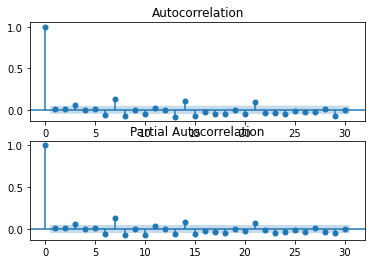

In [48]:
model = sm.tsa.statespace.SARIMAX(ds_method3, order=(3,0,3), seasonal_order = (0,0,0,12)).fit(max_iter=50, method='powell')
res = model.resid
fig, ax = plt.subplots(2,1)
fig = sm.graphics.tsa.plot_acf(res, lags=30, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(res, lags=30, ax=ax[1])
plt.show()

In [49]:
train = ds_method3.loc['2014-11-29':'2018-10-10']
test = ds_method3.loc['2019-09-24':]
stepwise_model.fit(train)

ARIMA(callback=None, disp=0, maxiter=None, method=None, order=(3, 0, 3),
   out_of_sample_size=0, scoring='mse', scoring_args={},
   seasonal_order=(0, 0, 0, 12), solver='lbfgs', start_params=None,
   suppress_warnings=True, transparams=True, trend=None,
   with_intercept=True)

In [50]:
mod = sm.tsa.statespace.SARIMAX(ds_method3,
                                order=(3,0,3),
                                seasonal_order=(0, 0, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:                  Steps   No. Observations:                 1720
Model:               SARIMAX(3, 0, 3)   Log Likelihood              -16383.214
Date:                Wed, 18 Nov 2020   AIC                          32780.429
Time:                        04:56:15   BIC                          32818.563
Sample:                             0   HQIC                         32794.539
                               - 1720                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5367      0.097     -5.540      0.000      -0.727      -0.347
ar.L2          0.9605      0.011     90.626      0.000       0.940       0.981
ar.L3          0.5698      0.093      6.146      0.0

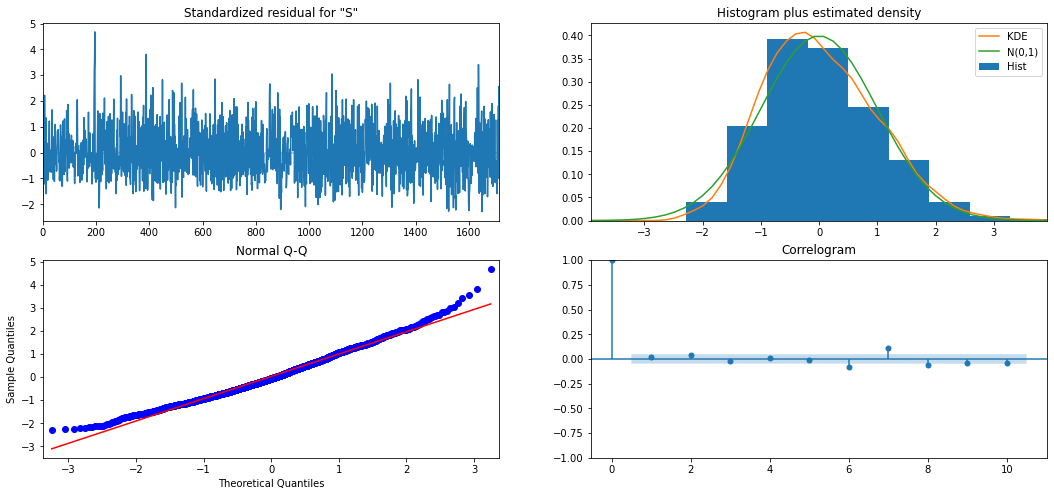

In [51]:
results.plot_diagnostics(figsize=(18, 8))
plt.show()

In [52]:
# the 20% point test data is on the specified date below
split_date = '2018-10-10'
data = ds_method3['Steps']
train, test = data[:split_date], data[split_date:]
test_len = len(test)
model = sm.tsa.statespace.SARIMAX(train,
                                order=(3,0,3),
                                seasonal_order=(0,0,0,12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
model_fit = model.fit(disp=-1)
prediction = model_fit.forecast(test_len)

In [53]:
pred_df = pd.DataFrame(np.array(prediction), index= test.index)
mae3 = mean_absolute_error(test.dropna(), pred_df.dropna())
mse3 = mean_squared_error(test.dropna(), pred_df.dropna())
rmse3 = math.sqrt(mse3)
print(f'Mean Squared Error: {mse3.round(4)}')
print(f'Root Mean Squared Error: {round(rmse3,4)}')
print(f'Mean Absolute Error: {mae3.round(4)}')

Mean Squared Error: 18925635.1767
Root Mean Squared Error: 4350.3604
Mean Absolute Error: 3501.6641


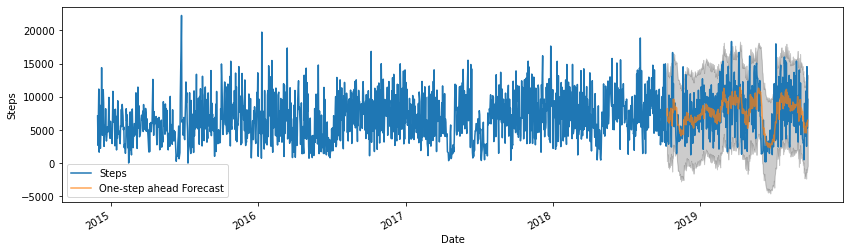

In [54]:
pred = results.get_prediction(start=pd.to_datetime('2018-10-10'), dynamic=False)
pred_ci = pred.conf_int()
#Potentially change the start date so its more zoomed in? 
ax = ds_method3['2014':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 4))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Steps')
plt.legend()
plt.show()

In [55]:
models = pd.DataFrame({
    'Method': ['Method 1', 'Method 2', 'Method 3'],
    'MSE': [round(mse1, 4), round(mse2, 4), round(mse3,4)],
    'RMSE': [round(rmse1,4 ), round(rmse2, 4), round(rmse3,4)],
    'MAE': [round(mae1, 4), round(mae2, 4), round(mae3,4)]})
models

,Method,MSE,RMSE,MAE
0,Method 1,2.052341e+07,4530.2769,3625.2001
1,Method 2,1.535083e+07,3918.0141,3220.2339
2,Method 3,1.892564e+07,4350.3604,3501.6641


Based on the above predictions, we can observe that **Method 2** and **Method 3** have a very similar prediction with **Method 1** performing the worst. However, the **RMSE** value of **Model 2** is lower, therefore, we can conclude that the **Method 2** performs the best here.